In [16]:
import sys 
sys.path.append('/Users/willknott/Desktop/DIS/coursework/pds/wdk24/src')

%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
from generation import generate_from_total_pdf
from distributions import total_cdf, total_pdf
from hypothesis_test import signal_background_test

In [18]:
# True parameter values
true_params, alpha, beta = {'f': 0.1, 'lam': 0.5, 'mu': 5.28, 'sigma': 0.018}, 5, 5.6
random_shifts = {
    'f': np.random.uniform(-0.09, 0.5), 
    'lam': np.random.uniform(-0.3, 1), 
    'mu': np.random.uniform(-0.25, 0.3), 
    'sigma': np.random.uniform(-0.01, 0.03)
}
starting_params = {}
for param in true_params:
    starting_params[param] = true_params[param] + random_shifts[param]
    starting_params[param] = float(f'{starting_params[param]:.4}')

In [19]:
n_datapoints = 20
n_init = 800
N = np.logspace(1, 6, num=n_datapoints).astype(int)
N = np.linspace(600, 1000, n_datapoints).astype(int)

all_data = [np.array([generate_from_total_pdf(N_events) for _ in range(n_init)]) for N_events in N]


Standard binomial error

In [20]:
def error_on_p(p, n):
    return np.sqrt((p*(1-p))/n)

### Hypothesis Testing

In [21]:
P = []
P_err = []
ns = []
for i, group_i in enumerate(all_data):
    n_i = n_init

    r_discoveries = 0
    for dataset in group_i:

        discovery, _, _ = signal_background_test(
            dataset=dataset, 
            pdf=total_pdf, 
            cdf=total_cdf, 
            starting_params=starting_params,
            binned=False, 
            plot=False
            )

        if discovery=='invalid minimum':
            n_i -= 1

        if discovery==True:
            r_discoveries += 1

    ns.append(n_i)

    p = r_discoveries/n_i
    P.append(p)
    P_err.append(error_on_p(p, n_i))

N, P, P_err = np.array(N), np.array(P), np.array(P_err)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -649.7                     │              Nfcn = 502              │
│ EDM = 2.96 (Goal: 0.0002)        │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ ABOVE EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬─────

/Users/willknott/miniconda3/envs/pds/lib/python3.12/site-packages/scipy/stats/_distn_infrastructure.py:2066: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/Users/willknott/miniconda3/envs/pds/lib/python3.12/site-packages/scipy/stats/_distn_infrastructure.py:1983: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -980.3                     │              Nfcn = 376              │
│ EDM = 8.14 (Goal: 0.0002)        │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ ABOVE EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬─────

# Finding `N_90`

In [22]:
print(N)
print(P)
print(P_err)

[ 600  621  642  663  684  705  726  747  768  789  810  831  852  873
  894  915  936  957  978 1000]
[0.84065245 0.87343358 0.88986233 0.89223058 0.90100251 0.91969887
 0.92065491 0.93358396 0.9235589  0.94862155 0.94486216 0.9510665
 0.96616541 0.96992481 0.96361355 0.96352201 0.97738693 0.96741855
 0.97741531 0.97371715]
[0.01296438 0.0117699  0.01107531 0.01097703 0.0105724  0.00962619
 0.00959176 0.00881479 0.00940577 0.00781512 0.00807993 0.00764151
 0.00640036 0.00604605 0.00663273 0.0066491  0.00526934 0.00628479
 0.00526281 0.00565952]


In [23]:
import pickle 

data_to_save = {
    'N': N,
    'P': P,
    'P_err': P_err
}

# Save the data to a pickle file
with open('PN_data.pkl', 'wb') as file:
    pickle.dump(data_to_save, file)

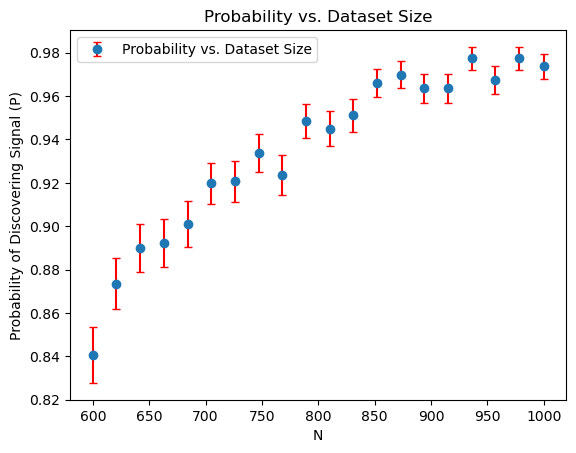

In [24]:
fig, ax = plt.subplots()
ax.errorbar(N, P, yerr=P_err, fmt='o', ecolor='red', capsize=3, label='Probability vs. Dataset Size')
ax.set_xlabel('N')
ax.set_ylabel('Probability of Discovering Signal (P)')
ax.set_title('Probability vs. Dataset Size')
ax.legend()

{'a': '(6.04e-10, 1.32e-09)',
 'b': '(-2.29e-06, 3.23e-06)',
 'c': '(0.00278, 0.00261)',
 'd': '(-0.12, 0.696)'}

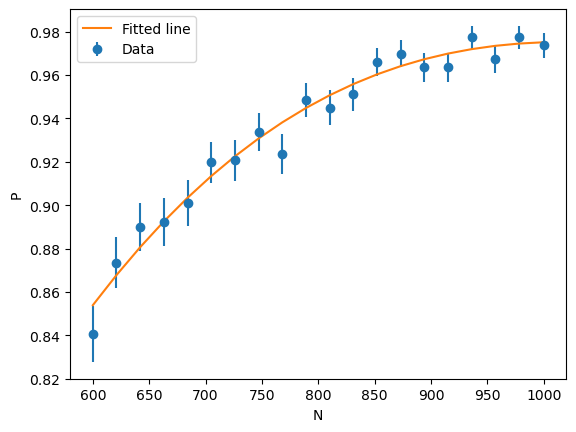

In [25]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

def third_degree(x, a, b, c, d):
    return a*(x**3) + b*(x**2) + c*x + d 
def fourth_degree(x, a, b, c, d, e):
    return a*(x**4) + b*(x**3) + c*(x**2) + d*x + e

# Replace 0 uncertainties with 0.00001 so as to 
# not produce errors in the least squares estimation
P_err[P_err == 0.0] = 0.00001

# ------------------
# should maybe use starting values
# ------------------
popt, pcov = curve_fit(third_degree, N, P, sigma=P_err, absolute_sigma=True)

fig, ax = plt.subplots()

# Plotting
ax.errorbar(N, P, yerr=P_err, fmt='o', label='Data')
ax.plot(N, third_degree(N, *popt), label='Fitted line')
ax.set_xlabel('N')
ax.set_ylabel('P')
ax.legend()

a, b, c, d = popt
a_err, b_err, c_err, d_err = np.sqrt(np.diag(pcov))

parameter_estimates = {
    'a': f'({a:.3}, {a_err:.3})',
    'b': f'({b:.3}, {b_err:.3})',
    'c': f'({c:.3}, {c_err:.3})',
    'd': f'({d:.3}, {d_err:.3})'
}

parameter_estimates

In [26]:
# from iminuit import Minuit

# N = reduced_N

# # Define the linear model
# def linear_model(N, m, b):
#     return m * N + b

# # Define the chi-squared function
# def chi2_linear(m, b):
#     return np.sum(((P - linear_model(N, m, b)) / P_err) ** 2)

# # Perform the minimization
# mi = Minuit(chi2_linear, m=3, b=-1)
# mi.limits['b'] = (-3, 1)
# mi.limits['m'] = (1, 20)
# mi.errordef = Minuit.LEAST_SQUARES
# mi.migrad()  # finds minimum of chi-square function

# # Get parameters and errors
# m_fit = mi.values['m']
# b_fit = mi.values['b']
# m_err = mi.errors['m']
# b_err = mi.errors['b']

# # Plotting
# plt.errorbar(N, P, yerr=P_err, fmt='o', label='Data')
# plt.plot(N, linear_model(N, *mi.values), label='Fitted line')
# plt.xlabel('N')
# plt.ylabel('P')
# plt.legend()
# plt.title('Linear Fit of P vs. N')
# plt.show()

# (m_fit, b_fit, m_err, b_err)